# Project: Firearm Background Checks by Demographics

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The Federal Bureau of Investigation (FBI) maintains a database of individuals who are ineligible to purchase a firearm. This database, called the National Instant Criminal Background Check System (NICS), allows firearm merchants to verify whether a customer is elible to purchase firearms. The laws requiring these checks vary state-to-state. The FBI publishes their data on the number of firearm checks by month, state, and type. The data included in this analysis covers November 1998 through November 2017.

Although this published data from the FBI is widely accepted as the best proxy for gun ownership, it is important to note its narrow scope. The data references the number of database checks that occurred, not the number of gun purchases, nor does it include any data from private gun sales. Not every NICS check leads to a completed purchase, and according to a Harvard study, roughly 40% of gun owners acquired their most recent firearm without undergoing a background check at all. 

This analysis also features data from the U.S. Census at the state level, and all of the data points are from 2010 or 2016, unless otherwise noted.

By combining the NICS data with the U.S. Census data, I plan to investigate the following questions:
- Which states have had the highest and lowest growth in gun checks from 2010 to 2016? 
- Which population group (minors, senior citizens, or women) is associated with lower or higher growth of NICS checks?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [2]:
# Load data and examine characteristics, including data that will need to be cleaned. 
def print_first_line(filename):
    name = filename.split('_')[0].split('/')[2]
    print('\n{}'.format(name))
    
    df = pd.read_csv(filename)
    print('\nHeader: {}'.format(df.head(1)))
    print('\nShape: {}'.format(df.shape))
    print('\nInfo: {}'.format(df.info()))
    print('\nDuplicates: {}\n'.format(sum(df.duplicated())))
    if name == 'census':
        print(df.iloc[:,0])

data_files = ['./data/gun_data.csv',
              './data/census_data.csv']

for file in data_files:
    print_first_line(file)


gun

Header:      month    state   permit  permit_recheck  handgun  long_gun  other  \
0  2017-09  Alabama  16717.0             0.0   5734.0    6320.0  221.0   

   multiple  admin  prepawn_handgun   ...    returned_other  rentals_handgun  \
0       317    0.0             15.0   ...               0.0              0.0   

   rentals_long_gun  private_sale_handgun  private_sale_long_gun  \
0               0.0                   9.0                   16.0   

   private_sale_other  return_to_seller_handgun  return_to_seller_long_gun  \
0                 3.0                       0.0                        0.0   

   return_to_seller_other  totals  
0                     3.0   32019  

[1 rows x 27 columns]

Shape: (12485, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
month                        12485 non-null object
state                        12485 non-null object
permit                       12461 non-null float64
perm

### Data Cleaning
In the NICS dataset, I'm limiting the data to specific columns: month and state to track check requests over time, and handgun, long gun, other, and multiple gun check requests. I excluded information for permits because differing state laws regarding concealed-carry permits makes the data inconsistent. I also excluded information for prepawns, redemptions, returns, rentals, and private sales to focus analysis on initial background checks for the purchase of firearms at approved licensee vendors. Additionally, I removed data related to U.S. territories since data from those areas is not included in the Census data. To clean the data, I created separate columns for the year and month of the check requests, changed the state names to lowercase with no spaces, and changed the appropriate data types to integers.

In the U.S. Census dataset, I transposed the data so states align with the rows of the NICS dataset. I excluded many of the data columns and renamed the remaining columns to focus on the overall population change, the under 18 population change, and the gender ratio change from 2010 to 2016. I also changed the state names to lowercase and removed the spaces, and I removed all percent signs and commas from the data. Finally, I changed the data types from strings to integers or floats where appropriate.

In [3]:
# import NICS data into a datframe
df_gun = pd.read_csv('./data/gun_data.csv')

In [4]:
# drop unwanted columns
drop_cols = np.r_[2,3,8:27]
drop_gun_col = list(df_gun.columns[drop_cols])
df_gun.drop(drop_gun_col, axis=1, inplace=True)

In [5]:
# clean state names
df_gun['state'] = df_gun['state'].str.lower()
df_gun.replace(' ','_', inplace=True, regex=True)

In [6]:
# remove unwanted rows
drop_rows = ['mariana_islands','district_of_columbia','guam','puerto_rico','virgin_islands']
for row in drop_rows:
    df_gun = df_gun[df_gun['state']!= row]

In [7]:
# split 'month' column into 'year' and 'month'
df_gun['year'] = df_gun['month'].apply((lambda x: x.split('-')[0]))
df_gun['month'] = df_gun['month'].apply((lambda x: x.split('-')[1]))

In [8]:
# change time columns to integers
convert_col = ['year','month']
for col in convert_col:
    df_gun[col] = df_gun[col].astype(int)

In [9]:
df_gun.head()

,month,state,handgun,long_gun,other,multiple,year
0,9,alabama,5734.0,6320.0,221.0,317,2017
1,9,alaska,2320.0,2930.0,219.0,160,2017
2,9,arizona,11063.0,7946.0,920.0,631,2017
3,9,arkansas,4347.0,6063.0,165.0,366,2017
4,9,california,37165.0,24581.0,2984.0,0,2017


In [10]:
# import census data as dataframe and transpose
df_census = pd.read_csv('./data/census_data.csv', index_col='Fact')
df_census = df_census.transpose()

In [11]:
# drop unwanted columns
drop_cols = np.r_[3:6,12:65]
drop_census_cols = list(df_census.columns[drop_cols])
df_census.drop(drop_census_cols, axis=1, inplace=True)
df_census.drop('Fact Note', axis=0, inplace=True)

In [12]:
# reset table index
df_census = df_census.reset_index()
df_census.index.names = ['index']

In [13]:
# rename remaining columns
new_names = ['state','pop_est_2016','pop_est_2010','pop_pct_change','<18_pct_2016',
             '<18_pct_2010','>=65_pct_2016','>=65_pct_2010','fem_pct_2016','fem_pct_2010']
ind = 0
for new_name in new_names:
    old_name = df_census.columns[ind]
    df_census.rename(index=str, columns={old_name:new_name}, inplace=True)
    ind += 1

In [14]:
# clean state names, remove all percent signs and commas
df_census['state'] = df_census['state'].str.lower()
df_census.replace([' ','%',','],['_','',''], inplace=True, regex=True)    

In [15]:
# change data to appropriate data types
int_columns = list(df_census.columns[1:3])
for col in int_columns:
    df_census[col] = (df_census[col].astype(int))
    
float_columns = list(df_census.columns[3:10])
for col in float_columns:
    df_census[col] = (df_census[col].astype(float))

In [16]:
df_census.head()

Fact,state,pop_est_2016,pop_est_2010,pop_pct_change,<18_pct_2016,<18_pct_2010,>=65_pct_2016,>=65_pct_2010,fem_pct_2016,fem_pct_2010
index,,,,,,,,,,
0,alabama,4863300,4780131,1.7,22.6,23.7,16.1,13.8,51.6,51.5
1,alaska,741894,710249,4.5,25.2,26.4,10.4,7.7,47.7,48.0
2,arizona,6931071,6392301,8.4,23.5,25.5,16.9,13.8,50.3,50.3
3,arkansas,2988248,2916025,2.5,23.6,24.4,16.3,14.4,50.9,50.9
4,california,39250017,37254522,5.4,23.2,25.0,13.6,11.4,50.3,50.3


In [17]:
# save dataframes as new csv files to use in analysis
df_gun.to_csv('./data/gun_data_cleaned.csv', index=False)
df_census.to_csv('./data/census_data_cleaned.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis

In [17]:
# load cleaned data sets
df_gun = pd.read_csv('./data/gun_data_cleaned.csv')
df_census = pd.read_csv('./data/census_data_cleaned.csv')

### Which states have had the highest and lowest growth in gun checks from 2010 to 2016? 

In [18]:
# calculate the total background checks across all types
df_gun['total']= df_gun['handgun']+df_gun['long_gun']+df_gun['other']+df_gun['multiple']

In [19]:
# calculate the total gun checks by state for each year
df_sums_2016 = df_gun.query('year==2016').groupby(['state'], as_index=False)['total'].sum()
df_sums_2010 = df_gun.query('year==2010').groupby(['state'], as_index=False)['total'].sum()

In [20]:
# calculate percent change: difference divided by first number * 100
index = np.arange(0,50)
columns = ['state','pct_change']

df_gun_pct_change = pd.DataFrame(index=index, columns=columns)
df_gun_pct_change['state'] = df_gun['state'][0:50]
df_gun_pct_change['pct_change'] = (df_sums_2016['total']-df_sums_2010['total'])*100/df_sums_2010['total']

# Fix null value for Hawaii (should be 0)
df_gun_pct_change['pct_change'].fillna(0.0, inplace=True)

In [21]:
# Sort table by percent change to find highest and lowest growths of gun checks
df_gun_pct_change.sort_values('pct_change', ascending=False, inplace=True)

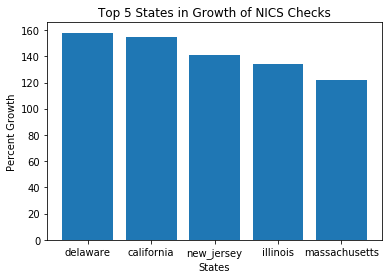

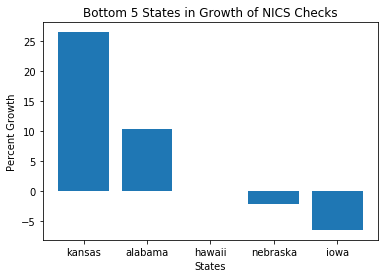

In [22]:
# Select top 5 states from percent change table
data = df_gun_pct_change['pct_change'][:5]

# Create bar graph
fig, ax = plt.subplots()
ind = list(np.arange(0,5))

top_states = df_gun_pct_change['state'][:5]
tick_labels = list(top_states)

plt.bar(ind, data)
ax.set_xticks(ind)
ax.set_xticklabels(tick_labels)
plt.title('Top 5 States in Growth of NICS Checks')
plt.xlabel('States')
plt.ylabel('Percent Growth')
plt.show();

# Select bottom 5 states from percent change table
data = df_gun_pct_change['pct_change'][-5:]

# Create bar graph
fig, ax = plt.subplots()
ind = list(np.arange(0,5))

bottom_states = df_gun_pct_change['state'][-5:]
tick_labels = list(bottom_states)

plt.bar(ind, data)
ax.set_xticks(ind)
ax.set_xticklabels(tick_labels)
plt.title('Bottom 5 States in Growth of NICS Checks')
plt.xlabel('States')
plt.ylabel('Percent Growth')
plt.show();

The top five states with the greatest increase of NICS checks are Delaware, California, New Jersey, Illinois, and Massachusetts. They all showed more than a 125% increase, and Delaware had nearly a 160% increase in checks across all gun types.

The five states with the lowest amount of change were Kansas, Alabama, Hawaii, Nebraska, and Iowa. Kansas showed over 25% increase in checks and Alabama trailed behind with a 10% increase. Hawaii had a rate of change of 0, due to not calling in any requests either year. Nebraska and Iowa actually showed negative growth, or a decrease, around 2% and 6% respectively.

### Which population group (minors, senior citizens, or women) is associated with lower or higher growth of NICS checks?

In [23]:
# Add gun data to the census dataframe, calculate checks per capita
df_gun_pct_change.sort_values('state', inplace=True)
df_census['gun_pct_chg'] = df_gun_pct_change['pct_change']
df_census['ch_per_cap_2016'] = df_sums_2016['total']/df_census['pop_est_2016']
df_census['ch_per_cap_2010'] = df_sums_2010['total']/df_census['pop_est_2010']

In [24]:
# Calculate percent change for the populations <18, >65, and women, and the percent change in per capita checks
df_census['<18_pct_chg'] = (df_census['<18_pct_2016']-df_census['<18_pct_2010'])*100/df_census['<18_pct_2010']
df_census['>=65_pct_chg'] = (df_census['>=65_pct_2016']-df_census['>=65_pct_2010'])*100/df_census['>=65_pct_2010']
df_census['fem_pct_chg'] = (df_census['fem_pct_2016']-df_census['fem_pct_2010'])*100/df_census['fem_pct_2010']
df_census['per_cap_pct_chg'] = (df_census['ch_per_cap_2016']-df_census['ch_per_cap_2010'])*100/df_census['ch_per_cap_2010']

In [25]:
# Prepare table for graphing variables of interest
df_pct_chg = df_census.copy()
cols = np.r_[1,2,4:13]
drop_cols = list(df_pct_chg.columns[cols])
df_pct_chg.drop(drop_cols, axis=1, inplace=True)

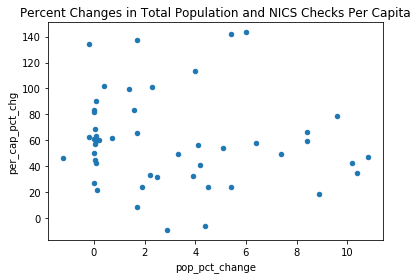

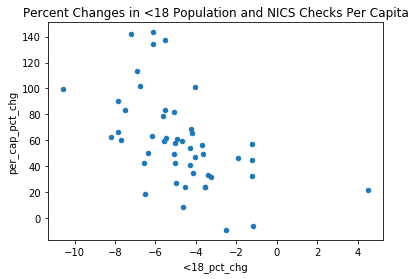

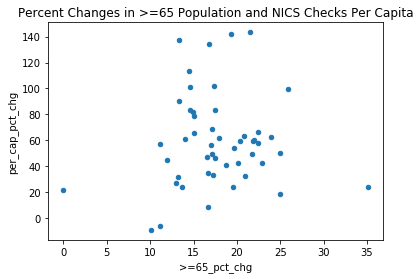

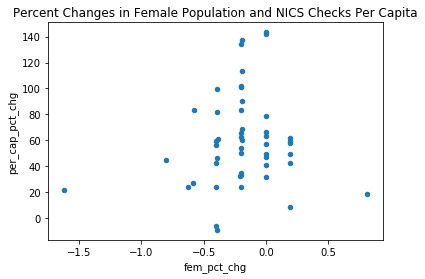

In [26]:
# Graph the four variables against the percent change in checks per capita
df_pct_chg.plot(x='pop_pct_change', y='per_cap_pct_chg', kind='scatter', title='Percent Changes in Total Population and NICS Checks Per Capita')
df_pct_chg.plot(x='<18_pct_chg', y='per_cap_pct_chg', kind='scatter', title='Percent Changes in <18 Population and NICS Checks Per Capita')
df_pct_chg.plot(x='>=65_pct_chg', y='per_cap_pct_chg', kind='scatter', title='Percent Changes in >=65 Population and NICS Checks Per Capita')
df_pct_chg.plot(x='fem_pct_chg', y='per_cap_pct_chg', kind='scatter', title='Percent Changes in Female Population and NICS Checks Per Capita');

There is no correlation between the percent change of a state's total population and the percent change in NICS checks per capita. There is also no correlation between the percent change in female population, or the >=65 population, and the percent change in NICS checks, although these two populations do have more closely distributed data than the total population. There appears to be a loose, negative correlation between the change in <18 population and per capita NICS checks. 

<a id='conclusions'></a>
## Conclusions

Nearly every state showed an increase in the number of NICS checks called in for the purchase of firearms. The top two states, Delaware and California, both had over a 150% increase in the number of checks from 2010 to 2016. Hawaii was unusual in that its growth was 0%; it had 0 checks for both 2010 and 2016. Only two states showed negative growth: Nebraska (~-2%) and Iowa (~-6%). Their negative growth is vastly outweighed by the growth of the 47 other states, revealing a greater trend toward higher NICS usage. 

The dataset, and thus the analysis, is limited because there is not a one-to-one correspondence of NICS checks to gun purchases; it is impossible to say whether gun sales also increased. Changes in state laws requiring more frequent checks of the NICS database could explain the observed growth even if underlying sales remained stagnant. Conversely, firearm sales from private vendors could be growing much faster than NICS checks convey. There is no way to determine the trend of actual gun sales without more detailed data.

When comparing the population changes within each state to the changes in NICS checks per capita, very little association is present. As the total population of the state grows, its inhabitants are neither more nor less likely to trigger an NICS check, and the changing population >=65 years old is also not associated with any change in NICS checks. The ratio of females to males within a state is not associated with any change in per capita NICS checks, either. There does appear to be some negative association between the changing population <18 years old and the per capita NICS checks. The states that had a smaller decrease in the number of people <18 also tended to have smaller increases of NICS checks, while the states that had a large decrease in the <18yo population also tended to have a much larger increase in the number of per capita NICS checks. Many reasons could explain this observation, however, and a more rigorous analyis is required to determine any causation. An area to explore further in future analyses is this relationship between the <18 years old population and the number of NICS checks to determine if a causal relationship can be found. Another area to explore is the legistlation passed within each state about NICS checks to determine if that has any effect on the growth seen in the states.